# 基于HDDM模拟2back任务

## 1.加载packages

In [1]:
import sys

print("Python 版本:", sys.version)

Python 版本: 3.9.13 | packaged by conda-forge | (main, May 27 2022, 17:23:23) 
[GCC 10.3.0]


In [2]:
%matplotlib inline

# scitnific computing and plotting
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns

# HDDM related packages
import pymc as pm
import hddm
import kabuki
import arviz as az
print("The current HDDM version is: ", hddm.__version__)
print("The current kabuki version is: ", kabuki.__version__)
print("The current PyMC version is: ", pm.__version__)
print("The current ArviZ version is: ", az.__version__)

The current HDDM version is:  1.0.1RC
The current kabuki version is:  0.6.5RC4
The current PyMC version is:  2.3.8
The current ArviZ version is:  0.15.1


## 2.导入数据集

In [3]:
! pip install openpyxl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.9/250.9 kB 376.9 kB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 24.1.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [4]:
import pandas as pd
import hddm
import matplotlib.pyplot as plt
import seaborn as sns

# 读取 Excel 文件
file_path = './rawdata.xlsx'
trial_data = pd.read_excel(file_path)

# 清理列名中的空格
trial_data.columns = trial_data.columns.str.strip()

# 确保反应时间列 'rt' 被转换为浮点数类型
trial_data['rt'] = pd.to_numeric(trial_data['rt'], errors='coerce')

# 确保 'Group' 列的数据类型为字符串，并去除可能的空格
trial_data['Group'] = trial_data['Group'].astype(str).str.strip()

# 检查数据
print(trial_data.tail())
print(f"The number of trials: {trial_data.shape[0]}")
print(f"The number of variables: {trial_data.shape[1]}")
print(f"The number of participants: {trial_data['subj_idx'].unique().shape[0]}")

# 重新命名必要的列，确保与 HDDM 的要求一致
data = hddm.utils.flip_errors(trial_data)

# 数据检查完成，准备后续模型的构建

          ID  subj_idx  response     rt Group
16296  16363       272         1  0.123     1
16297  16364       272         1  0.172     1
16298  16365       272         0  0.027     1
16299  16366       272         0  0.023     1
16300  16367       272         0  0.143     1
The number of trials: 16301
The number of variables: 5
The number of participants: 211


In [5]:
data=trial_data

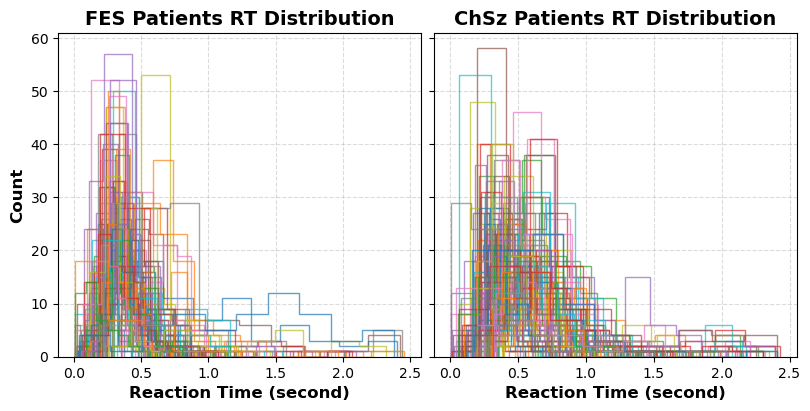

In [6]:
import matplotlib.pyplot as plt

# 分组标签映射（字符串类型）
group_labels = {
    '1': 'FES Patients',
    '2': 'ChSz Patients'
}

# 确保组的顺序为 ['1', '2']
groups = ['1', '2']

# 创建子图
fig, axs = plt.subplots(1, len(groups), figsize=(8, 4), sharey=True, constrained_layout=True)

for idx, group in enumerate(groups):
    group_data = data[data['Group'] == group]
    ax = axs[idx]  # 当前子图
    ax.set_title(f"{group_labels[group]} RT Distribution", fontsize=14, weight='bold')
    
    # 绘制每个 subj_idx 的反应时间分布
    for subj_idx, subj_data in group_data.groupby('subj_idx'):
        subj_data.rt.hist(bins=10, histtype='step', ax=ax, alpha=0.7)
    
    ax.set_xlabel('Reaction Time (second)', fontsize=12, weight='bold')
    if idx == 0:  # 仅在第一个子图中设置 Y 轴标签
        ax.set_ylabel('Count', fontsize=12, weight='bold')
    
    # 添加网格线
    ax.grid(axis='both', linestyle='--', alpha=0.45)  # 设置网格线为虚线，透明度为 0.7

# 保存图像
plt.savefig('rt_distributions_by_group_with_grid.jpg', dpi=1200, bbox_inches='tight')
plt.show()

In [7]:
# 检查 Group 列的唯一值及其数据类型
print(data['Group'].unique())
print(data['Group'].dtype)

# 确保 Group 列的值为字符串类型，并移除可能存在的空格
data['Group'] = data['Group'].astype(str).str.strip()

# 再次计算 Group 1 和 Group 2 中的唯一被试数量
unique_group1_subjects = data[data['Group'] == '1']['subj_idx'].nunique()
unique_group2_subjects = data[data['Group'] == '2']['subj_idx'].nunique()

print(f"First episode of schizophrenia = {unique_group1_subjects}")
print(f"Chronic schizophrenia = {unique_group2_subjects}")

['2' '1']
object
First episode of schizophrenia = 103
Chronic schizophrenia = 108


#### 1.模型设计

In [8]:
import hddm

# 打印数据的类型，确保数据格式正确
# 数据应为一个 Pandas DataFrame，包含反应时间（RT）、正确性（accuracy）以及组别等列
print(f"Data type: {type(data)}")

# 基础模型（m0）：包含所有核心参数和变异性参数
# 该模型不考虑条件或组别，只用于全局参数估计
m0 = hddm.HDDM(
    data, 
    include=['a', 'v', 't', 'z', 'sv', 'sz', 'st']  # 包含所有参数和变异性参数
)

# 综合模型（m2）：分层模型，探索所有组别间参数的变化
# 假设核心参数（a, v, t, z）依赖于组别（Group）
m1 = hddm.HDDM(
    data, 
    include=['a', 'v', 't', 'z', 'sv', 'st', 'sz'],  # 包含所有核心参数和变异性参数
    depends_on={  # 假设参数依赖于组别
        'a': ['Group'], 
        'v': ['Group'], 
        't': ['Group'],
        'z': ['Group']
    }
)


# 回归模型（m3v）：分析组别对漂移率（v）的影响
m2v = hddm.HDDMRegressor(
    data,
    "v ~ 1 + C(Group, Treatment('2'))",  # 漂移率 v 的回归公式，Group 为分组变量，'2' 为参考组
    include=['a', 'v', 't', 'z', 'sv', 'st', 'sz'],  # 包含所有核心参数和变异性参数
    group_only_regressors=False,  # 允许个体层面的变化
    keep_regressor_trace=True  # 保留回归系数的 MCMC 采样轨迹
)

# 回归模型（m3z）：分析组别对起始点偏移（z）的影响
m2z = hddm.HDDMRegressor(
    data,
    "z ~ 1 + C(Group, Treatment('2'))",  # 起始点 z 的回归公式
    include=['a', 'v', 't', 'z', 'sv', 'st', 'sz'],
    group_only_regressors=False,
    keep_regressor_trace=True
)

# 回归模型（m3a）：分析组别对决策界限（a）的影响
m2a = hddm.HDDMRegressor(
    data,
    "a ~ 1 + C(Group, Treatment('2'))",  # 决策界限 a 的回归公式
    include=['a', 'v', 't', 'z', 'sv', 'st', 'sz'],
    group_only_regressors=False,
    keep_regressor_trace=True
)

# 回归模型（m3t）：分析组别对非决策时间（t）的影响
m2t = hddm.HDDMRegressor(
    data,
    "t ~ 1 + C(Group, Treatment('2'))",  # 非决策时间 t 的回归公式
    include=['a', 'v', 't', 'z', 'sv', 'st', 'sz'],
    group_only_regressors=False,
    keep_regressor_trace=True
)

# 打印模型初始化完成的信息
print('模型已成功初始化！😄')

Data type: <class 'pandas.core.frame.DataFrame'>
No model attribute --> setting up standard HDDM
Set model to full_ddm
No model attribute --> setting up standard HDDM
Set model to full_ddm
No model attribute --> setting up standard HDDM
Set model to full_ddm
No model attribute --> setting up standard HDDM
Set model to full_ddm
No model attribute --> setting up standard HDDM
Set model to full_ddm
No model attribute --> setting up standard HDDM
Set model to full_ddm
模型已成功初始化！😄


#### 2.模型拟合参数量 

In [9]:
def run_sampling(
    m,
    n_samples=10000,  # 10,000
    n_burn=5000,     # 5000
    n_chains=4,      # 4
    thin=2,  # Thinning：每隔2个样本保留1个
    model_name="m",
    progress_bar=True
):
    m_infdata = m.sample(
        n_samples,
        burn=n_burn,
        chains=n_chains,
        return_infdata=True,
        save_name="8.model_fitted/" + model_name,
        progress_bar=progress_bar
    )

    return m, m_infdata


# 计算时间估计
print('拟合参数设置成功!')

拟合参数设置成功!


**注：在配备 2.90GHz 英特尔®酷睿™i7-10700 处理器的电脑上，用上述设置（10000 个样本）拟合所有这六个模型大约需要 8-9 个小时。此外，内存应足够大，建议使用 ~ 64 G 内存。否则，建议使用少量样本（如 n_samples=2500，burn=1000）。

#### 3.读取之前好的模型😂

In [10]:
import pickle

# 模型和推断数据的文件名
model_names = ["m2a","m2t","m2v","m2z"] 
 
# 创建字典存储模型和推断数据
models = {}
infdata = {}

# 加载所有模型和推断数据
for name in model_names:
    model_file_path = f'./2.模型拟合-输出/{name}_model.pkl'
    infdata_file_path = f'./2.模型拟合-输出/{name}_infdata.pkl'
    
    # 重新加载模型
    with open(model_file_path, 'rb') as f_model:
        models[name] = pickle.load(f_model)
    
    # 重新加载推断数据
    with open(infdata_file_path, 'rb') as f_infdata:
        infdata[name] = pickle.load(f_infdata)
    
    # 动态赋值回原始变量名
    globals()[name] = models[name]
    globals()[f"{name}_infdata"] = infdata[name]
    
    print(f"{name} 已经成功挂载!")

# 打印已加载的模型和推断数据
for name in model_names:
    print(f"{name} 模型:", globals()[name])
    print(f"{name} 推断数据:", globals()[f"{name}_infdata"])

print('所有模型和推断数据读取成功!😂')

m2a 已经成功挂载!
m2t 已经成功挂载!
m2v 已经成功挂载!
m2z 已经成功挂载!
m2a 模型: <hddm.models.hddm_regression.HDDMRegressor object at 0xffff7996f910>
m2a 推断数据: Inference data with groups:
	> posterior
	> observed_data
m2t 模型: <hddm.models.hddm_regression.HDDMRegressor object at 0xffff008a3a30>
m2t 推断数据: Inference data with groups:
	> posterior
	> observed_data
m2v 模型: <hddm.models.hddm_regression.HDDMRegressor object at 0xffff0082ad60>
m2v 推断数据: Inference data with groups:
	> posterior
	> observed_data
m2z 模型: <hddm.models.hddm_regression.HDDMRegressor object at 0xffff0d019670>
m2z 推断数据: Inference data with groups:
	> posterior
	> observed_data
所有模型和推断数据读取成功!😂


In [11]:
import pickle

# 模型和推断数据的文件名
model_names = ["m0","m1",] 
 
# 创建字典存储模型和推断数据
models = {}
infdata = {}

# 加载所有模型和推断数据
for name in model_names:
    model_file_path = f'./2.模型拟合-输出/{name}_model.pkl'
    infdata_file_path = f'./2.模型拟合-输出/{name}_infdata.pkl'
    
    # 重新加载模型
    with open(model_file_path, 'rb') as f_model:
        models[name] = pickle.load(f_model)
    
    # 重新加载推断数据
    with open(infdata_file_path, 'rb') as f_infdata:
        infdata[name] = pickle.load(f_infdata)
    
    # 动态赋值回原始变量名
    globals()[name] = models[name]
    globals()[f"{name}_infdata"] = infdata[name]
    
    print(f"{name} 已经成功挂载!")

# 打印已加载的模型和推断数据
for name in model_names:
    print(f"{name} 模型:", globals()[name])
    print(f"{name} 推断数据:", globals()[f"{name}_infdata"])

print('所有模型和推断数据读取成功!😂')

m0 已经成功挂载!
m1 已经成功挂载!
m0 模型: <hddm.models.hddm_info.HDDM object at 0xffff0fc03df0>
m0 推断数据: Inference data with groups:
	> posterior
	> observed_data
m1 模型: <hddm.models.hddm_info.HDDM object at 0xffff0fc03d00>
m1 推断数据: Inference data with groups:
	> posterior
	> observed_data
所有模型和推断数据读取成功!😂


In [12]:
import pickle

# 定义模型名称列表
model_names = ["m2a","m2t","m2v","m2z"]
posterior_distributions = {}

# 循环加载每个模型并提取后验分布
for model_name in model_names:
    print(f"提取 {model_name} 的后验分布...")
    
    # 加载模型
    with open(f'./2.模型拟合-输出/{model_name}_model.pkl', 'rb') as f_model:
        model_loaded = pickle.load(f_model)
    
    # 提取后验分布
    posterior_samples = model_loaded.get_traces()
    
    # 将每个模型的后验分布存储在字典中
    posterior_distributions[model_name] = posterior_samples
    
    # 打印提取的后验分布的前几行
    print(f"{model_name}的后验分布提取完成:")

print("所有模型的后验分布提取完成！😂")


#得20分钟

提取 m2a 的后验分布...
m2a的后验分布提取完成:
提取 m2t 的后验分布...
m2t的后验分布提取完成:
提取 m2v 的后验分布...
m2v的后验分布提取完成:
提取 m2z 的后验分布...
m2z的后验分布提取完成:
所有模型的后验分布提取完成！😂


In [13]:
import pickle

# 定义模型名称列表
model_names = ["m0","m1"]
posterior_distributions = {}

# 循环加载每个模型并提取后验分布
for model_name in model_names:
    print(f"提取 {model_name} 的后验分布...")
    
    # 加载模型
    with open(f'./2.模型拟合-输出/{model_name}_model.pkl', 'rb') as f_model:
        model_loaded = pickle.load(f_model)
    
    # 提取后验分布
    posterior_samples = model_loaded.get_traces()
    
    # 将每个模型的后验分布存储在字典中
    posterior_distributions[model_name] = posterior_samples
    
    # 打印提取的后验分布的前几行
    print(f"{model_name}的后验分布提取完成:")

print("所有模型的后验分布提取完成！😂")


#得20分钟

提取 m0 的后验分布...
m0的后验分布提取完成:
提取 m1 的后验分布...
m1的后验分布提取完成:
所有模型的后验分布提取完成！😂


#### 4.查看内存

In [14]:
import psutil
print(f"Available memory: {psutil.virtual_memory().available / (1024**3):.2f} GB")

Available memory: 7.48 GB


## 3.模型诊断

#### （1）方法1.Trace plot

We can also only plot selected parameters' traces. 
 
- use regex to select var_names that start with "a" and do not contain either "subj" or "std".

print(tmp_infdata.posterior.dims)
print(tmp_infdata.posterior.coords)
print(tmp_infdata.posterior.data_vars)##### M0

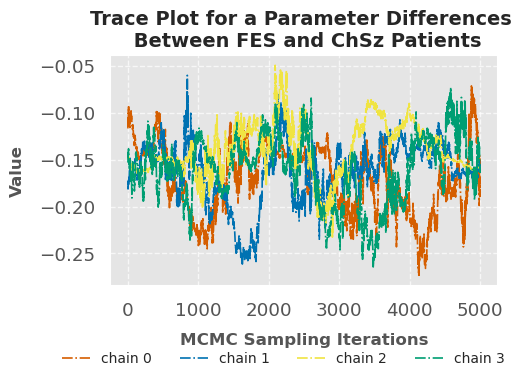

In [44]:
import matplotlib.pyplot as plt
import os  # 导入 os 模块以创建文件夹

# 模型名称列表
model_names = ['m2a']  

# 定义需要检查的参数
parameters = ['a_C(Group, Treatment(\'2\'))[T.1]']

# 自定义 chain 颜色（为4个链设置颜色）

chain_colors = ['#D55E00', '#0072B2', '#F0E442', '#009E73']  # 高对比Nature风格配色
# 外部循环，遍历每个模型
for model_name in model_names:
    # 获取加载的推断数据
    tmp_infdata = globals()[f'{model_name}_infdata']
    
    # 为每个模型创建文件夹
    output_folder = f'3.模型诊断-输出/{model_name}'
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # 内部循环，遍历每个参数，生成 trace plot
    for param in parameters:
        # 确定 var_names 列表（直接基于参数名称）
        var_names = [f'{param}']  # 如果变量名有其他特定规则，可以调整生成逻辑

        # 手动绘制每个链的轨迹
        for var_name in var_names:
            fig, ax = plt.subplots(figsize=(5, 3))

            # 手动绘制每条链
            for i, color in enumerate(chain_colors):
                chain_data = tmp_infdata.posterior[var_name].sel(chain=i)
               
                ax.plot(chain_data, color=color, label=f'chain {i}', linestyle='-.', linewidth=1.2)
            # 添加 X 轴和 Y 轴标签，并设置字体为粗体，增加 pad
            ax.set_xlabel("MCMC Sampling Iterations", fontsize=12, fontweight='bold', labelpad=10)  # 设置 X 轴标签，增加 pad 和粗体
            ax.set_ylabel(f'Value', fontsize=12, fontweight='bold', labelpad=10)  # 设置 Y 轴标签，增加 pad 和粗体

            # 设置标题，将 var_name 和 'Trace Plot' 结合
            ax.set_title(f'Trace Plot for a Parameter Differences \n Between FES and ChSz Patients', fontsize=14, fontweight='bold')

            ax.grid(True, linestyle='--', alpha=0.7)
            ax.legend(
                fontsize=10, 
                frameon=False,  # 去掉外边框
                ncol=4, 
                fancybox=True, 
                bbox_to_anchor=(1.05, -0.23)
            )

            # 保存图片为 600 DPI 的 JPEG 格式到对应模型的文件夹
            plt.savefig(f'{output_folder}/{model_name}_{param}_trace_plot2a.jpg', dpi=1200, format='jpg', bbox_inches='tight')
            plt.show()

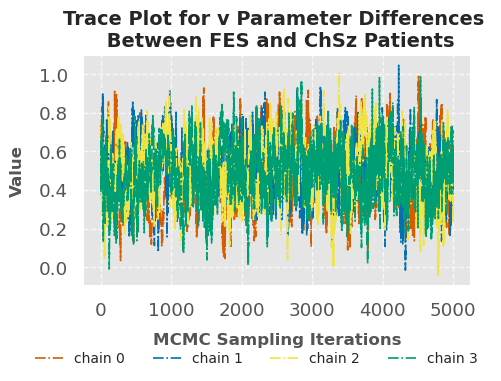

In [45]:
import matplotlib.pyplot as plt
import os  # 导入 os 模块以创建文件夹

# 模型名称列表
model_names = ['m2v']  

# 定义需要检查的参数
parameters = ['v_C(Group, Treatment(\'2\'))[T.1]']

# 自定义 chain 颜色（为4个链设置颜色）

chain_colors = ['#D55E00', '#0072B2', '#F0E442', '#009E73']  # 高对比Nature风格配色
# 外部循环，遍历每个模型
for model_name in model_names:
    # 获取加载的推断数据
    tmp_infdata = globals()[f'{model_name}_infdata']
    
    # 为每个模型创建文件夹
    output_folder = f'3.模型诊断-输出/{model_name}'
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # 内部循环，遍历每个参数，生成 trace plot
    for param in parameters:
        # 确定 var_names 列表（直接基于参数名称）
        var_names = [f'{param}']  # 如果变量名有其他特定规则，可以调整生成逻辑

        # 手动绘制每个链的轨迹
        for var_name in var_names:
            fig, ax = plt.subplots(figsize=(5, 3))

            # 手动绘制每条链
            for i, color in enumerate(chain_colors):
                chain_data = tmp_infdata.posterior[var_name].sel(chain=i)
               
                ax.plot(chain_data, color=color, label=f'chain {i}', linestyle='-.', linewidth=1.2)
            # 添加 X 轴和 Y 轴标签，并设置字体为粗体，增加 pad
            ax.set_xlabel("MCMC Sampling Iterations", fontsize=12, fontweight='bold', labelpad=10)  # 设置 X 轴标签，增加 pad 和粗体
            ax.set_ylabel(f'Value', fontsize=12, fontweight='bold', labelpad=10)  # 设置 Y 轴标签，增加 pad 和粗体

            # 设置标题，将 var_name 和 'Trace Plot' 结合
            ax.set_title(f'Trace Plot for v Parameter Differences \n Between FES and ChSz Patients', fontsize=14, fontweight='bold')

            ax.grid(True, linestyle='--', alpha=0.7)
            ax.legend(
                fontsize=10, 
                frameon=False,  # 去掉外边框
                ncol=4, 
                fancybox=True, 
                bbox_to_anchor=(1.05, -0.23)
            )

            # 保存图片为 600 DPI 的 JPEG 格式到对应模型的文件夹
            plt.savefig(f'{output_folder}/{model_name}_{param}_trace_plot2v.jpg', dpi=1200, format='jpg', bbox_inches='tight')
            plt.show()

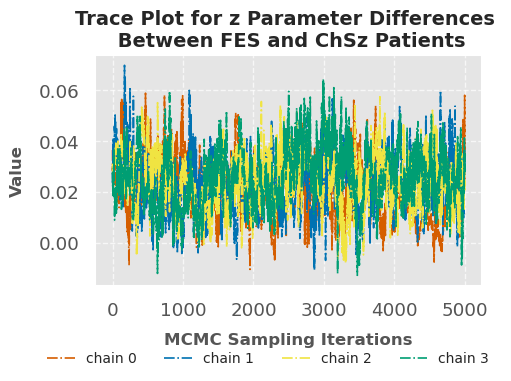

In [46]:
import matplotlib.pyplot as plt
import os  # 导入 os 模块以创建文件夹

# 模型名称列表
model_names = ['m2z']  

# 定义需要检查的参数
parameters = ['z_C(Group, Treatment(\'2\'))[T.1]']

# 自定义 chain 颜色（为4个链设置颜色）

chain_colors = ['#D55E00', '#0072B2', '#F0E442', '#009E73']  # 高对比Nature风格配色
# 外部循环，遍历每个模型
for model_name in model_names:
    # 获取加载的推断数据
    tmp_infdata = globals()[f'{model_name}_infdata']
    
    # 为每个模型创建文件夹
    output_folder = f'3.模型诊断-输出/{model_name}'
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # 内部循环，遍历每个参数，生成 trace plot
    for param in parameters:
        # 确定 var_names 列表（直接基于参数名称）
        var_names = [f'{param}']  # 如果变量名有其他特定规则，可以调整生成逻辑

        # 手动绘制每个链的轨迹
        for var_name in var_names:
            fig, ax = plt.subplots(figsize=(5, 3))

            # 手动绘制每条链
            for i, color in enumerate(chain_colors):
                chain_data = tmp_infdata.posterior[var_name].sel(chain=i)
               
                ax.plot(chain_data, color=color, label=f'chain {i}', linestyle='-.', linewidth=1.2)
            # 添加 X 轴和 Y 轴标签，并设置字体为粗体，增加 pad
            ax.set_xlabel("MCMC Sampling Iterations", fontsize=12, fontweight='bold', labelpad=10)  # 设置 X 轴标签，增加 pad 和粗体
            ax.set_ylabel(f'Value', fontsize=12, fontweight='bold', labelpad=10)  # 设置 Y 轴标签，增加 pad 和粗体

            # 设置标题，将 var_name 和 'Trace Plot' 结合
            ax.set_title(f'Trace Plot for z Parameter Differences \n Between FES and ChSz Patients', fontsize=14, fontweight='bold')

            ax.grid(True, linestyle='--', alpha=0.7)
            ax.legend(
                fontsize=10, 
                frameon=False,  # 去掉外边框
                ncol=4, 
                fancybox=True, 
                bbox_to_anchor=(1.05, -0.23)
            )

            # 保存图片为 600 DPI 的 JPEG 格式到对应模型的文件夹
            plt.savefig(f'{output_folder}/{model_name}_{param}_trace_plot2z.jpg', dpi=1200, format='jpg', bbox_inches='tight')
            plt.show()

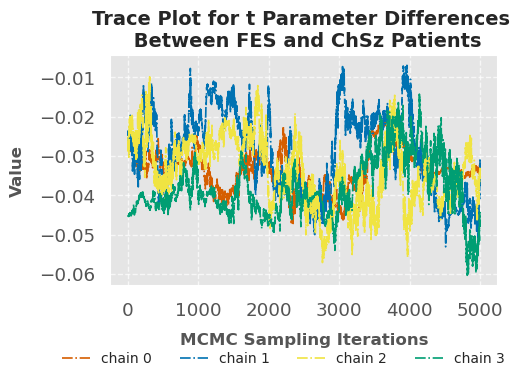

In [47]:
import matplotlib.pyplot as plt
import os  # 导入 os 模块以创建文件夹

# 模型名称列表
model_names = ['m2t']  

# 定义需要检查的参数
parameters = ['t_C(Group, Treatment(\'2\'))[T.1]']

# 自定义 chain 颜色（为4个链设置颜色）

chain_colors = ['#D55E00', '#0072B2', '#F0E442', '#009E73']  # 高对比Nature风格配色
# 外部循环，遍历每个模型
for model_name in model_names:
    # 获取加载的推断数据
    tmp_infdata = globals()[f'{model_name}_infdata']
    
    # 为每个模型创建文件夹
    output_folder = f'3.模型诊断-输出/{model_name}'
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # 内部循环，遍历每个参数，生成 trace plot
    for param in parameters:
        # 确定 var_names 列表（直接基于参数名称）
        var_names = [f'{param}']  # 如果变量名有其他特定规则，可以调整生成逻辑

        # 手动绘制每个链的轨迹
        for var_name in var_names:
            fig, ax = plt.subplots(figsize=(5, 3))

            # 手动绘制每条链
            for i, color in enumerate(chain_colors):
                chain_data = tmp_infdata.posterior[var_name].sel(chain=i)
               
                ax.plot(chain_data, color=color, label=f'chain {i}', linestyle='-.', linewidth=1.2)
            # 添加 X 轴和 Y 轴标签，并设置字体为粗体，增加 pad
            ax.set_xlabel("MCMC Sampling Iterations", fontsize=12, fontweight='bold', labelpad=10)  # 设置 X 轴标签，增加 pad 和粗体
            ax.set_ylabel(f'Value', fontsize=12, fontweight='bold', labelpad=10)  # 设置 Y 轴标签，增加 pad 和粗体

            # 设置标题，将 var_name 和 'Trace Plot' 结合
            ax.set_title(f'Trace Plot for t Parameter Differences \n Between FES and ChSz Patients', fontsize=14, fontweight='bold')

            ax.grid(True, linestyle='--', alpha=0.7)
            ax.legend(
                fontsize=10, 
                frameon=False,  # 去掉外边框
                ncol=4, 
                fancybox=True, 
                bbox_to_anchor=(1.05, -0.23)
            )

            # 保存图片为 600 DPI 的 JPEG 格式到对应模型的文件夹
            plt.savefig(f'{output_folder}/{model_name}_{param}_trace_plot2t.jpg', dpi=1200, format='jpg', bbox_inches='tight')
            plt.show()

#### （2）方法2. $\hat{R}$ and ESS

In [19]:
import pandas as pd
import arviz as az

# 假设你已经在之前的代码中动态加载了推断数据
model_data = [m2a_infdata]  # 使用正确的全局变量名
model_names = ['m2a']

# 循环处理每个模型
for model_name, tmp_infdata in zip(model_names, model_data):
    
    # 获取R-hat大于1.1的参数及其诊断统计量
    summary_tmp = az.summary(tmp_infdata, kind="diagnostics", round_to=4)
    problem_params = summary_tmp[summary_tmp["r_hat"] > 1.1]

    # 打印问题参数
    print(f"问题参数😭 - {model_name}:")
    print(problem_params)

    # 将问题参数保存为Excel文件
    problem_params.to_excel(f"3.模型诊断-输出/problem_params-{model_name}.xlsx", index=True)
    print(f"已成功将问题参数保存至 problem_params-{model_name}.xlsx 文件")

    # 获取R-hat小于等于1.1的参数
    good_params = summary_tmp[summary_tmp["r_hat"] <= 1.1]

    # 打印收敛良好的参数
    print(f"收敛良好的参数😂 - {model_name}:")
    print(good_params)

    # 将收敛良好的参数保存为Excel文件
    good_params.to_excel(f"3.模型诊断-输出/good_params-{model_name}.xlsx", index=True)
    print(f"已成功将收敛良好的参数保存至 good_params-{model_name}.xlsx 文件")

    # 只计算 ESS
    ess_values = az.ess(tmp_infdata).values
    print(f"模型 {model_name} 的 ESS 值：")
    print(ess_values)


问题参数😭 - m2a:
                                     mcse_mean  mcse_sd  ess_bulk  ess_tail   
a_C(Group, Treatment('2'))[T.1]_std     0.0044   0.0031   22.2677   28.7918  \

                                      r_hat  
a_C(Group, Treatment('2'))[T.1]_std  1.1209  
已成功将问题参数保存至 problem_params-m2a.xlsx 文件
收敛良好的参数😂 - m2a:
                                          mcse_mean  mcse_sd    ess_bulk   
v                                            0.0012   0.0009   4060.2666  \
v_std                                        0.0010   0.0007   3387.7040   
v_subj.2                                     0.0032   0.0022   7678.0980   
v_subj.4                                     0.0038   0.0027  10134.1355   
v_subj.5                                     0.0029   0.0021  13547.5903   
...                                             ...      ...         ...   
a_C(Group, Treatment('2'))[T.1]_subj.263     0.0055   0.0043    104.8131   
a_C(Group, Treatment('2'))[T.1]_subj.264     0.0054   0.0044    105.6800 

In [20]:
import pandas as pd
import arviz as az

# 假设你已经在之前的代码中动态加载了推断数据
model_data = [m2v_infdata]  # 使用正确的全局变量名
model_names = ['m2v']

# 循环处理每个模型
for model_name, tmp_infdata in zip(model_names, model_data):
    
    # 获取R-hat大于1.1的参数及其诊断统计量
    summary_tmp = az.summary(tmp_infdata, kind="diagnostics", round_to=4)
    problem_params = summary_tmp[summary_tmp["r_hat"] > 1.1]

    # 打印问题参数
    print(f"问题参数😭 - {model_name}:")
    print(problem_params)

    # 将问题参数保存为Excel文件
    problem_params.to_excel(f"3.模型诊断-输出/problem_params-{model_name}.xlsx", index=True)
    print(f"已成功将问题参数保存至 problem_params-{model_name}.xlsx 文件")

    # 获取R-hat小于等于1.1的参数
    good_params = summary_tmp[summary_tmp["r_hat"] <= 1.1]

    # 打印收敛良好的参数
    print(f"收敛良好的参数😂 - {model_name}:")
    print(good_params)

    # 将收敛良好的参数保存为Excel文件
    good_params.to_excel(f"3.模型诊断-输出/good_params-{model_name}.xlsx", index=True)
    print(f"已成功将收敛良好的参数保存至 good_params-{model_name}.xlsx 文件")

    # 只计算 ESS
    ess_values = az.ess(tmp_infdata).values
    print(f"模型 {model_name} 的 ESS 值：")
    print(ess_values)


问题参数😭 - m2v:
Empty DataFrame
Columns: [mcse_mean, mcse_sd, ess_bulk, ess_tail, r_hat]
Index: []
已成功将问题参数保存至 problem_params-m2v.xlsx 文件
收敛良好的参数😂 - m2v:
                                          mcse_mean  mcse_sd   ess_bulk   
a                                            0.0003   0.0002  5189.5536  \
a_std                                        0.0002   0.0002  5867.4993   
a_subj.2                                     0.0008   0.0006  8216.3692   
a_subj.4                                     0.0008   0.0006  5924.2005   
a_subj.5                                     0.0006   0.0004  7923.6310   
...                                             ...      ...        ...   
v_C(Group, Treatment('2'))[T.1]_subj.263     0.0221   0.0156   638.7755   
v_C(Group, Treatment('2'))[T.1]_subj.264     0.0071   0.0098  9490.2717   
v_C(Group, Treatment('2'))[T.1]_subj.265     0.0100   0.0071  3091.4481   
v_C(Group, Treatment('2'))[T.1]_subj.266     0.0082   0.0097  7358.4361   
v_C(Group, Treatment('2'

In [21]:
import pandas as pd
import arviz as az

# 假设你已经在之前的代码中动态加载了推断数据
model_data = [m2t_infdata]  # 使用正确的全局变量名
model_names = ['m2t']

# 循环处理每个模型
for model_name, tmp_infdata in zip(model_names, model_data):
    
    # 获取R-hat大于1.1的参数及其诊断统计量
    summary_tmp = az.summary(tmp_infdata, kind="diagnostics", round_to=4)
    problem_params = summary_tmp[summary_tmp["r_hat"] > 1.1]

    # 打印问题参数
    print(f"问题参数😭 - {model_name}:")
    print(problem_params)

    # 将问题参数保存为Excel文件
    problem_params.to_excel(f"3.模型诊断-输出/problem_params-{model_name}.xlsx", index=True)
    print(f"已成功将问题参数保存至 problem_params-{model_name}.xlsx 文件")

    # 获取R-hat小于等于1.1的参数
    good_params = summary_tmp[summary_tmp["r_hat"] <= 1.1]

    # 打印收敛良好的参数
    print(f"收敛良好的参数😂 - {model_name}:")
    print(good_params)

    # 将收敛良好的参数保存为Excel文件
    good_params.to_excel(f"3.模型诊断-输出/good_params-{model_name}.xlsx", index=True)
    print(f"已成功将收敛良好的参数保存至 good_params-{model_name}.xlsx 文件")

    # 只计算 ESS
    ess_values = az.ess(tmp_infdata).values
    print(f"模型 {model_name} 的 ESS 值：")
    print(ess_values)


问题参数😭 - m2t:
                                          mcse_mean  mcse_sd  ess_bulk   
t_Intercept_subj.272                         0.0039   0.0029   11.6158  \
t_C(Group, Treatment('2'))[T.1]              0.0021   0.0015   18.2178   
t_C(Group, Treatment('2'))[T.1]_std          0.0021   0.0015    9.0578   
t_C(Group, Treatment('2'))[T.1]_subj.140     0.0021   0.0015   50.2806   
t_C(Group, Treatment('2'))[T.1]_subj.200     0.0022   0.0016   44.5108   
t_C(Group, Treatment('2'))[T.1]_subj.272     0.0038   0.0030   11.5434   

                                          ess_tail   r_hat  
t_Intercept_subj.272                       20.0079  1.2695  
t_C(Group, Treatment('2'))[T.1]            89.2655  1.1968  
t_C(Group, Treatment('2'))[T.1]_std        21.0738  1.3574  
t_C(Group, Treatment('2'))[T.1]_subj.140  122.5339  1.1005  
t_C(Group, Treatment('2'))[T.1]_subj.200  122.9484  1.1041  
t_C(Group, Treatment('2'))[T.1]_subj.272   17.0933  1.2725  
已成功将问题参数保存至 problem_params-m2t.xlsx 文件
收敛

In [22]:
import pandas as pd
import arviz as az

# 假设你已经在之前的代码中动态加载了推断数据
model_data = [m2z_infdata]  # 使用正确的全局变量名
model_names = ['m2z']

# 循环处理每个模型
for model_name, tmp_infdata in zip(model_names, model_data):
    
    # 获取R-hat大于1.1的参数及其诊断统计量
    summary_tmp = az.summary(tmp_infdata, kind="diagnostics", round_to=4)
    problem_params = summary_tmp[summary_tmp["r_hat"] > 1.1]

    # 打印问题参数
    print(f"问题参数😭 - {model_name}:")
    print(problem_params)

    # 将问题参数保存为Excel文件
    problem_params.to_excel(f"3.模型诊断-输出/problem_params-{model_name}.xlsx", index=True)
    print(f"已成功将问题参数保存至 problem_params-{model_name}.xlsx 文件")

    # 获取R-hat小于等于1.1的参数
    good_params = summary_tmp[summary_tmp["r_hat"] <= 1.1]

    # 打印收敛良好的参数
    print(f"收敛良好的参数😂 - {model_name}:")
    print(good_params)

    # 将收敛良好的参数保存为Excel文件
    good_params.to_excel(f"3.模型诊断-输出/good_params-{model_name}.xlsx", index=True)
    print(f"已成功将收敛良好的参数保存至 good_params-{model_name}.xlsx 文件")

    # 只计算 ESS
    ess_values = az.ess(tmp_infdata).values
    print(f"模型 {model_name} 的 ESS 值：")
    print(ess_values)


问题参数😭 - m2z:
Empty DataFrame
Columns: [mcse_mean, mcse_sd, ess_bulk, ess_tail, r_hat]
Index: []
已成功将问题参数保存至 problem_params-m2z.xlsx 文件
收敛良好的参数😂 - m2z:
                                          mcse_mean  mcse_sd   ess_bulk   
a                                            0.0003   0.0002  6783.3338  \
a_std                                        0.0002   0.0002  6243.1693   
a_subj.2                                     0.0008   0.0006  8172.3255   
a_subj.4                                     0.0008   0.0006  5538.9203   
a_subj.5                                     0.0006   0.0004  8568.5396   
...                                             ...      ...        ...   
z_C(Group, Treatment('2'))[T.1]_subj.263     0.0013   0.0009   714.7056   
z_C(Group, Treatment('2'))[T.1]_subj.264     0.0006   0.0008  4052.6273   
z_C(Group, Treatment('2'))[T.1]_subj.265     0.0007   0.0011  4073.4137   
z_C(Group, Treatment('2'))[T.1]_subj.266     0.0007   0.0009  3506.3338   
z_C(Group, Treatment('2'

## 4. 模型比较与选择

In [23]:
! pip3 install tabulate


[notice] A new release of pip is available: 24.1.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


+----------+---------+
| model    |     DIC |
+==========+=========+
| Model 1  | 5921.85 |
+----------+---------+
| Model 0  | 5927.66 |
+----------+---------+
| Model 2v | 5929.48 |
+----------+---------+
| Model 2z | 5936.45 |
+----------+---------+
| Model 2t | 5941.09 |
+----------+---------+
| Model 2a | 5944.47 |
+----------+---------+


/tmp/ipykernel_44/1623798792.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(y='model', x='DIC', data=comp_dic, palette=colors)


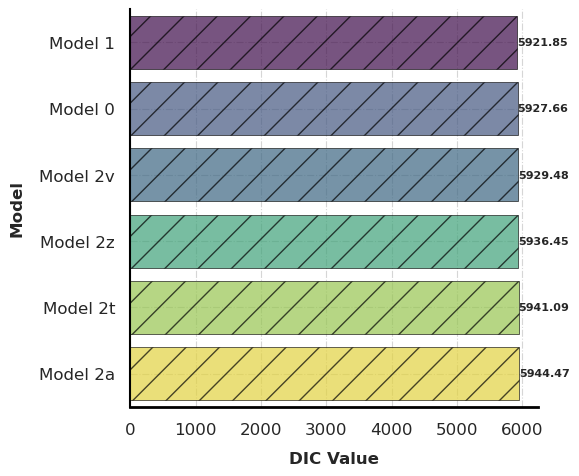

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 模拟DIC数据，使用模型的具体名称
dic_dict = {
    "Model 1": m0.dic,
    "Model 0": m1.dic,
    "Model 2a": m2a.dic,
    "Model 2t": m2t.dic,
    "Model 2v": m2v.dic,
    "Model 2z": m2z.dic,
}

# 将字典转换为Pandas DataFrame,并按照DIC值升序排序
comp_dic = pd.DataFrame.from_dict(dic_dict, orient='index', columns=['DIC'])
comp_dic['model'] = comp_dic.index
comp_dic = comp_dic[['model', 'DIC']]
comp_dic = comp_dic.sort_values(by=['DIC'], ascending=True)

# 打印三线表
print(comp_dic.to_markdown(index=False, tablefmt="grid"))

# 设置绘图风格，使用符合Nature风格的简洁主题
sns.set(style="whitegrid", font_scale=1.2)

# 创建颜色映射，颜色越大越深
norm = plt.Normalize(comp_dic['DIC'].min(), comp_dic['DIC'].max())
colors = plt.cm.viridis(norm(comp_dic['DIC']))  # 使用 vivid 色彩映射

# 创建柱状图，将 X 和 Y 轴对调
plt.figure(figsize=(6, 5))
bar_plot = sns.barplot(y='model', x='DIC', data=comp_dic, palette=colors)

# 为柱状图中的每个柱子设置透明度、边框粗细和花纹
for patch in bar_plot.patches:
    patch.set_alpha(0.7)  # 设置透明度为0.7
    patch.set_edgecolor('black')  # 设置边框颜色为黑色
    patch.set_linewidth(0.6)  # 设置边框粗细为0.6
    patch.set_hatch('/')  # 设置花纹，'/'表示斜线

# 在柱子上标注具体数值
for i, patch in enumerate(bar_plot.patches):
    width = patch.get_width()
    bar_plot.text(width + 0.5,  # 数值标签的x坐标稍高于柱子顶部
                  patch.get_y() + patch.get_height() / 2,
                  f'{width:.2f}',  # 显示2位小数
                  ha='left', 
                  va='center', 
                  fontsize=8, 
                  weight='bold')

# 添加图形标题和坐标轴标签
bar_plot.set_ylabel("Model", fontsize=12, weight='bold')
bar_plot.set_xlabel("DIC Value", fontsize=12, weight='bold')

# 调整标签和风格，参考Nature风格
bar_plot.tick_params(axis='both', which='major', labelsize=12)
bar_plot.spines['top'].set_visible(False)
bar_plot.spines['right'].set_visible(False)

# 设置左和底部的边框为黑色，并加粗
bar_plot.spines['left'].set_linewidth(1.5)
bar_plot.spines['left'].set_color('black')  # 改为黑色
bar_plot.spines['bottom'].set_linewidth(2)
bar_plot.spines['bottom'].set_color('black')  # 改为黑色

# 设置网格线的透明度和粗细
bar_plot.grid(True, which='major', axis='x', linestyle='-.', linewidth=0.8, alpha=0.8)  # 现在对x轴应用网格线
bar_plot.grid(True, which='major', axis='y', linestyle='-.', linewidth=0.8, alpha=0.8)

# 调整布局以防止标签被截断
plt.tight_layout()

# 保存图片到指定文件夹，并确保不会截断图像
plt.savefig("4.模型比较-输出/DIC_comparison-m2.jpg", dpi=600, format='jpeg', bbox_inches='tight')  # 使用bbox_inches='tight'来防止截断

# 显示图形
plt.show()

In [49]:
# 计算模型间的 DIC 差异
comp_dic['ΔDIC'] = comp_dic['DIC'] - comp_dic['DIC'].min()

# 打印三线表
print(comp_dic.to_markdown(index=False, tablefmt="grid"))

+----------+---------+----------+
| model    |     DIC |     ΔDIC |
+==========+=========+==========+
| Model 1  | 5921.85 |  0       |
+----------+---------+----------+
| Model 0  | 5927.66 |  5.80568 |
+----------+---------+----------+
| Model 2v | 5929.48 |  7.62442 |
+----------+---------+----------+
| Model 2z | 5936.45 | 14.6009  |
+----------+---------+----------+
| Model 2t | 5941.09 | 19.2399  |
+----------+---------+----------+
| Model 2a | 5944.47 | 22.6128  |
+----------+---------+----------+


## 5. 统计推断

这里我们仅示范如何使用 ROPE + HDI 方法。

假设我们对冲突水平对漂移率 v 的影响感兴趣，并且我们使用 [-0.2, 0.2] 作为 ROPE。
然后我们可以使用 az.plot_posterior() 可视化 ROPE 和 HDI。4

### 1.查看字段 + 输出后验参数

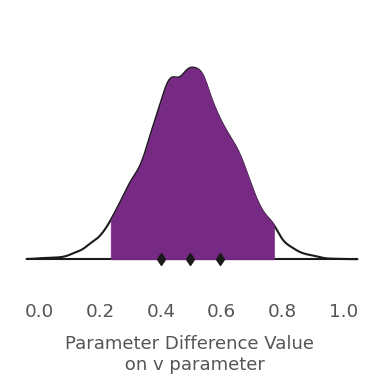

In [35]:
import os
import arviz as az
import matplotlib.pyplot as plt

# 定义模型和参数
model_data = {
    'm2v': ('v_C(Group, Treatment(\'2\'))[T.1]', m2v_infdata)  # 感兴趣的参数
}

# 遍历模型和参数
for model_name, (param, infdata) in model_data.items():
    # 创建图形和子图
    fig, ax = plt.subplots(figsize=(4, 4))

    # 设置背景透明
    ax.set_facecolor("none")

    # 绘制后验分布（森林图 / ridge plot）
    az.plot_forest(
        infdata,
        kind='ridgeplot',
        var_names=[param],  # 只针对特定参数
        linewidth=1.5,
        ridgeplot_overlap=3,  # 调整重叠程度
        ridgeplot_truncate=False,
        ridgeplot_quantiles=[0.25, 0.5, 0.75],  # 添加四分位数
        combined=True,
        colors='#762a83',  # 使用自定义颜色
        ax=ax
    )

    # 移除 Y 轴标签
    ax.set_yticks([])
    ax.set_yticklabels([])

    # 设置标题和轴标签
   
    ax.set_xlabel('Parameter Difference Value \n on v parameter', fontsize=13)  # X轴标签

    # 调整布局
    plt.tight_layout()

    # 确保保存路径存在
    save_dir = '6.统计推断-输出/组间差异'
    os.makedirs(save_dir, exist_ok=True)  # 自动创建文件夹

    # 保存图像
    save_path = os.path.join(save_dir, f'Differences_in_FES_and_ChSz_patients_{model_name}.jpg')
    plt.savefig(save_path, dpi=1200, bbox_inches='tight', transparent=True)  # 设置透明背景

    # 显示图像
    plt.show()

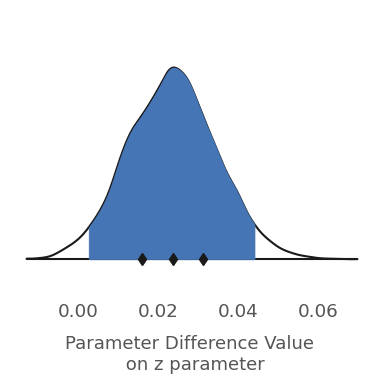

In [36]:
import os
import arviz as az
import matplotlib.pyplot as plt

# 定义模型和参数
model_data = {
    'm2z': ('z_C(Group, Treatment(\'2\'))[T.1]', m2z_infdata)  # 感兴趣的参数
}

# 遍历模型和参数
for model_name, (param, infdata) in model_data.items():
    # 创建图形和子图
    fig, ax = plt.subplots(figsize=(4, 4))

    # 设置背景透明
    ax.set_facecolor("none")

    # 绘制后验分布（森林图 / ridge plot）
    az.plot_forest(
        infdata,
        kind='ridgeplot',
        var_names=[param],  # 只针对特定参数
        linewidth=1.5,
        ridgeplot_overlap=3,  # 调整重叠程度
        ridgeplot_truncate=False,
        ridgeplot_quantiles=[0.25, 0.5, 0.75],  # 添加四分位数
        combined=True,
        colors='#4575b4',  # 使用自定义颜色
        ax=ax
    )

    # 移除 Y 轴标签
    ax.set_yticks([])
    ax.set_yticklabels([])

    # 设置标题和轴标签
   
    ax.set_xlabel('Parameter Difference Value \n on z parameter', fontsize=13)  # X轴标签

    # 调整布局
    plt.tight_layout()

    # 确保保存路径存在
    save_dir = '6.统计推断-输出/组间差异'
    os.makedirs(save_dir, exist_ok=True)  # 自动创建文件夹

    # 保存图像
    save_path = os.path.join(save_dir, f'Differences_in_FES_and_ChSz_patients_{model_name}.jpg')
    plt.savefig(save_path, dpi=1200, bbox_inches='tight', transparent=True)  # 设置透明背景

    # 显示图像
    plt.show()

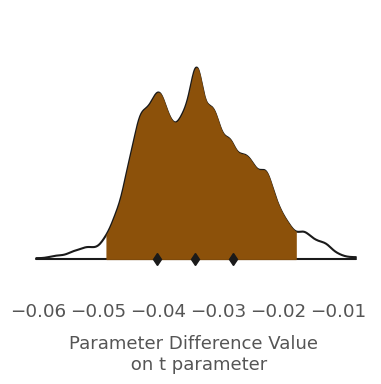

In [37]:
import os
import arviz as az
import matplotlib.pyplot as plt

# 定义模型和参数
model_data = {
    'm2t': ('t_C(Group, Treatment(\'2\'))[T.1]', m2t_infdata)  # 感兴趣的参数
}

# 遍历模型和参数
for model_name, (param, infdata) in model_data.items():
    # 创建图形和子图
    fig, ax = plt.subplots(figsize=(4, 4))

    # 设置背景透明
    ax.set_facecolor("none")

    # 绘制后验分布（森林图 / ridge plot）
    az.plot_forest(
        infdata,
        kind='ridgeplot',
        var_names=[param],  # 只针对特定参数
        linewidth=1.5,
        ridgeplot_overlap=3,  # 调整重叠程度
        ridgeplot_truncate=False,
        ridgeplot_quantiles=[0.25, 0.5, 0.75],  # 添加四分位数
        combined=True,
        colors='#8c510a',  # 使用自定义颜色
        ax=ax
    )

    # 移除 Y 轴标签
    ax.set_yticks([])
    ax.set_yticklabels([])

    # 设置标题和轴标签
   
    ax.set_xlabel('Parameter Difference Value \n on t parameter', fontsize=13)  # X轴标签

    # 调整布局
    plt.tight_layout()

    # 确保保存路径存在
    save_dir = '6.统计推断-输出/组间差异'
    os.makedirs(save_dir, exist_ok=True)  # 自动创建文件夹

    # 保存图像
    save_path = os.path.join(save_dir, f'Differences_in_FES_and_ChSz_patients_{model_name}.jpg')
    plt.savefig(save_path, dpi=1200, bbox_inches='tight', transparent=True)  # 设置透明背景

    # 显示图像
    plt.show()

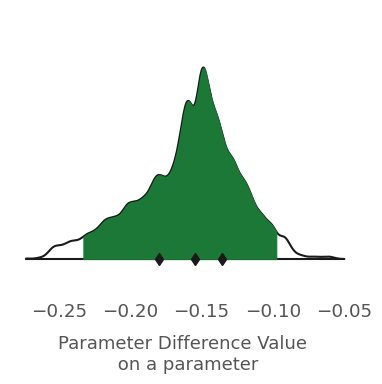

In [43]:
import os
import arviz as az
import matplotlib.pyplot as plt

# 定义模型和参数
model_data = {
    'm2a': ('a_C(Group, Treatment(\'2\'))[T.1]', m2a_infdata)  # 感兴趣的参数
}

# 遍历模型和参数
for model_name, (param, infdata) in model_data.items():
    # 创建图形和子图
    fig, ax = plt.subplots(figsize=(4, 4))

    # 设置背景透明
    ax.set_facecolor("none")

    # 绘制后验分布（森林图 / ridge plot）
    az.plot_forest(
        infdata,
        kind='ridgeplot',
        var_names=[param],  # 只针对特定参数
        linewidth=1.5,
        ridgeplot_overlap=3,  # 调整重叠程度
        ridgeplot_truncate=False,
        ridgeplot_quantiles=[0.25, 0.5, 0.75],  # 添加四分位数
        combined=True,
        colors='#1b7837',  # 使用自定义颜色
        ax=ax
    )

    # 移除 Y 轴标签
    ax.set_yticks([])
    ax.set_yticklabels([])

    # 设置标题和轴标签
   
    ax.set_xlabel('Parameter Difference Value \n on a parameter', fontsize=13)  # X轴标签

    # 调整布局
    plt.tight_layout()

    # 确保保存路径存在
    save_dir = '6.统计推断-输出/组间差异'
    os.makedirs(save_dir, exist_ok=True)  # 自动创建文件夹

    # 保存图像
    save_path = os.path.join(save_dir, f'Differences_in_FES_and_ChSz_patients_{model_name}.jpg')
    plt.savefig(save_path, dpi=1200, bbox_inches='tight', transparent=True)  # 设置透明背景

    # 显示图像
    plt.show()

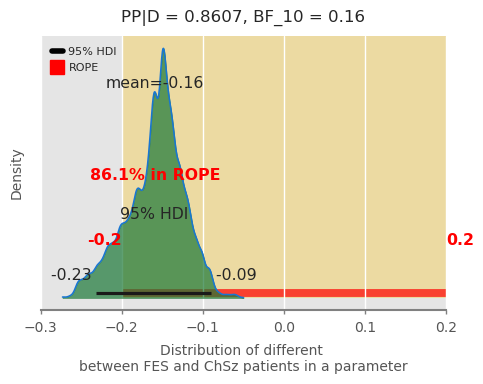

┌────────────┬───────────────┬───────────────┬───────────────┬────────────┬─────────┐
│ Parameter  │ Mean Difference │ 95% HDI Lower │ 95% HDI Upper │   PP|D    │ BF_{10} │
├────────────┼───────────────┼───────────────┼───────────────┼────────────┼─────────┤
│ a_C(Group, │        -0.1587 │       -0.2312 │       -0.0899 │     0.8607 │    0.16 │
└────────────┴───────────────┴───────────────┴───────────────┴────────────┴─────────┘


In [38]:
import arviz as az
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.lines import Line2D

# 配置全局样式
plt.style.use('ggplot')  # 更换图风格为 'ggplot'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['axes.labelpad'] = 10
plt.rcParams['xtick.major.pad'] = 5
plt.rcParams['ytick.major.pad'] = 5

# 定义模型和感兴趣的参数
model_data = {
    'm2a': ('a_C(Group, Treatment(\'2\'))[T.1]', m2a_infdata)  # 感兴趣的参数
}

# 创建单行图布局
fig, axes = plt.subplots(1, 1, figsize=(5, 4))  # 单个子图

# 存储结果的列表
results = []

# 遍历模型和参数
for model_name, (param, infdata) in model_data.items():
    # 提取后验样本
    posterior_samples = infdata.posterior[param].values.flatten()

    # 计算后验分布的均值和 95% HDI
    mean_diff = posterior_samples.mean()
    hdi_95_diff = az.hdi(posterior_samples, hdi_prob=0.95)

    # 计算 PP|D（差异是否接近0）
    ppd_diff = ((posterior_samples > -0.2) & (posterior_samples < 0.2)).mean()

    # 计算 BF_{10}
    bf_10_diff = (1 - ppd_diff) / ppd_diff

    # 绘制后验分布图
    az.plot_posterior(
        posterior_samples,
        kind='kde',
        hdi_prob=0.95,
        rope=[-0.2, 0.2],
        textsize=10,
        rope_color='red',
        ax=axes,
        color='#1976D2',
    )

    # 获取x和y坐标，用于填充
    x_vals = axes.lines[0].get_xdata()
    y_vals = axes.lines[0].get_ydata()

    # 使用 fill_between 方法进行填充
    axes.fill_between(x_vals, y_vals, color='#1b7837', alpha=0.7)

    # 设置图形格式
    axes.set_xlim(-0.3, 0.2)  # 根据数据范围调整 X 轴范围
    axes.set_xlabel(f'Distribution of different \nbetween FES and ChSz patients in a parameter', fontsize=10, labelpad=6)
    axes.set_ylabel('Density', fontsize=10, labelpad=12)
    axes.set_title(f'PP|D = {ppd_diff:.4f}, BF_{10} = {bf_10_diff:.2f}', fontsize=12, pad=10)

    # 添加填充矩形
    rect = plt.Rectangle((-0.2, 0), 0.4, axes.get_ylim()[1], 
                         linewidth=0, facecolor='#FFC107', alpha=0.3,
                         zorder=-1)
    axes.add_patch(rect)

    # 自定义图例符号
    custom_lines = [
        Line2D([0], [0], color='black', lw=4),  # 黑色线，表示95% HDI
        Line2D([0], [0], color='red', marker='s', markersize=10, linestyle='None')  # 红色方块，表示ROPE
    ]

    # 添加图例
    axes.legend(custom_lines, ["95% HDI", "ROPE"], loc='upper left', fontsize=8, 
                frameon=False, edgecolor='none', fancybox=False, 
                borderpad=0.5, handlelength=1.0, handletextpad=0.5)

    # 存储结果
    results.append({
        "Parameter": param,
        "Mean Difference": mean_diff,
        "95% HDI Lower": hdi_95_diff[0],
        "95% HDI Upper": hdi_95_diff[1],
        "PP|D": ppd_diff,
        "BF_{10}": bf_10_diff
    })

# 调整布局和显示图像
plt.tight_layout()
plt.savefig('6.统计推断-输出/组间差异/a_C_Group_Treatment_2_m2a.jpg', dpi=1200, bbox_inches='tight', transparent=True)  # 设置透明背景
plt.show()

# 将结果转换为 DataFrame 并打印为三线表
df_results = pd.DataFrame(results)

# 格式化数值
df_results['Mean Difference'] = df_results['Mean Difference'].map('{:.4f}'.format)
df_results['95% HDI Lower'] = df_results['95% HDI Lower'].map('{:.4f}'.format)
df_results['95% HDI Upper'] = df_results['95% HDI Upper'].map('{:.4f}'.format)
df_results['PP|D'] = df_results['PP|D'].map('{:.4f}'.format)
df_results['BF_{10}'] = df_results['BF_{10}'].map('{:.2f}'.format)

# 打印为三线表格式
print("┌────────────┬───────────────┬───────────────┬───────────────┬────────────┬─────────┐")
print("│ Parameter  │ Mean Difference │ 95% HDI Lower │ 95% HDI Upper │   PP|D    │ BF_{10} │")
print("├────────────┼───────────────┼───────────────┼───────────────┼────────────┼─────────┤")
for index, row in df_results.iterrows():
    print(f"│ {row['Parameter'][:10]:>10} │ {row['Mean Difference']:>14} │ {row['95% HDI Lower']:>13} │ {row['95% HDI Upper']:>13} │ {row['PP|D']:>10} │ {row['BF_{10}']:>7} │")
print("└────────────┴───────────────┴───────────────┴───────────────┴────────────┴─────────┘")

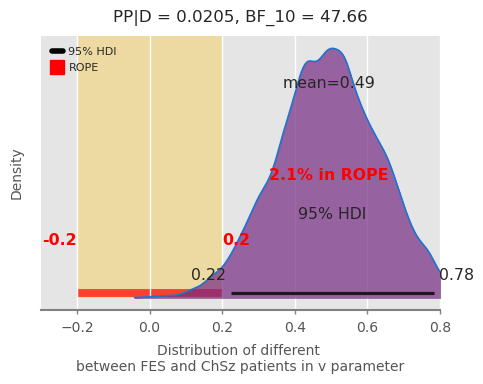

┌────────────┬───────────────┬───────────────┬───────────────┬────────────┬─────────┐
│ Parameter  │ Mean Difference │ 95% HDI Lower │ 95% HDI Upper │   PP|D    │ BF_{10} │
├────────────┼───────────────┼───────────────┼───────────────┼────────────┼─────────┤
│ v_C(Group, │         0.4941 │        0.2244 │        0.7826 │     0.0205 │   47.66 │
└────────────┴───────────────┴───────────────┴───────────────┴────────────┴─────────┘


In [39]:
import arviz as az
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.lines import Line2D

# 配置全局样式
plt.style.use('ggplot')  # 更换图风格为 'ggplot'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['axes.labelpad'] = 10
plt.rcParams['xtick.major.pad'] = 5
plt.rcParams['ytick.major.pad'] = 5

# 定义模型和感兴趣的参数
model_data = {
    'm2v': ('v_C(Group, Treatment(\'2\'))[T.1]', m2v_infdata)  # 感兴趣的参数
}

# 创建单行图布局
fig, axes = plt.subplots(1, 1, figsize=(5, 4))  # 单个子图

# 存储结果的列表
results = []

# 遍历模型和参数
for model_name, (param, infdata) in model_data.items():
    # 提取后验样本
    posterior_samples = infdata.posterior[param].values.flatten()

    # 计算后验分布的均值和 95% HDI
    mean_diff = posterior_samples.mean()
    hdi_95_diff = az.hdi(posterior_samples, hdi_prob=0.95)

    # 计算 PP|D（差异是否接近0）
    ppd_diff = ((posterior_samples > -0.2) & (posterior_samples < 0.2)).mean()

    # 计算 BF_{10}
    bf_10_diff = (1 - ppd_diff) / ppd_diff

    # 绘制后验分布图
    az.plot_posterior(
        posterior_samples,
        kind='kde',
        hdi_prob=0.95,
        rope=[-0.2, 0.2],
        textsize=10,
        rope_color='red',
        ax=axes,
        color='#1976D2',
    )

    # 获取x和y坐标，用于填充
    x_vals = axes.lines[0].get_xdata()
    y_vals = axes.lines[0].get_ydata()

    # 使用 fill_between 方法进行填充
    axes.fill_between(x_vals, y_vals, color='#762a83', alpha=0.7)

    # 设置图形格式
    axes.set_xlim(-0.3, 0.8)  # 根据数据范围调整 X 轴范围
    axes.set_xlabel(f'Distribution of different \nbetween FES and ChSz patients in v parameter', fontsize=10, labelpad=6)
    axes.set_ylabel('Density', fontsize=10, labelpad=12)
    axes.set_title(f'PP|D = {ppd_diff:.4f}, BF_{10} = {bf_10_diff:.2f}', fontsize=12, pad=10)

    # 添加填充矩形
    rect = plt.Rectangle((-0.2, 0), 0.4, axes.get_ylim()[1], 
                         linewidth=0, facecolor='#FFC107', alpha=0.3,
                         zorder=-1)
    axes.add_patch(rect)

    # 自定义图例符号
    custom_lines = [
        Line2D([0], [0], color='black', lw=4),  # 黑色线，表示95% HDI
        Line2D([0], [0], color='red', marker='s', markersize=10, linestyle='None')  # 红色方块，表示ROPE
    ]

    # 添加图例
    axes.legend(custom_lines, ["95% HDI", "ROPE"], loc='upper left', fontsize=8, 
                frameon=False, edgecolor='none', fancybox=False, 
                borderpad=0.5, handlelength=1.0, handletextpad=0.5)

    # 存储结果
    results.append({
        "Parameter": param,
        "Mean Difference": mean_diff,
        "95% HDI Lower": hdi_95_diff[0],
        "95% HDI Upper": hdi_95_diff[1],
        "PP|D": ppd_diff,
        "BF_{10}": bf_10_diff
    })

# 调整布局和显示图像
plt.tight_layout()
plt.savefig('6.统计推断-输出/组间差异/a_C_Group_Treatment_2_m2v.jpg', dpi=1200, bbox_inches='tight', transparent=True)  # 设置透明背景
plt.show()

# 将结果转换为 DataFrame 并打印为三线表
df_results = pd.DataFrame(results)

# 格式化数值
df_results['Mean Difference'] = df_results['Mean Difference'].map('{:.4f}'.format)
df_results['95% HDI Lower'] = df_results['95% HDI Lower'].map('{:.4f}'.format)
df_results['95% HDI Upper'] = df_results['95% HDI Upper'].map('{:.4f}'.format)
df_results['PP|D'] = df_results['PP|D'].map('{:.4f}'.format)
df_results['BF_{10}'] = df_results['BF_{10}'].map('{:.2f}'.format)

# 打印为三线表格式
print("┌────────────┬───────────────┬───────────────┬───────────────┬────────────┬─────────┐")
print("│ Parameter  │ Mean Difference │ 95% HDI Lower │ 95% HDI Upper │   PP|D    │ BF_{10} │")
print("├────────────┼───────────────┼───────────────┼───────────────┼────────────┼─────────┤")
for index, row in df_results.iterrows():
    print(f"│ {row['Parameter'][:10]:>10} │ {row['Mean Difference']:>14} │ {row['95% HDI Lower']:>13} │ {row['95% HDI Upper']:>13} │ {row['PP|D']:>10} │ {row['BF_{10}']:>7} │")
print("└────────────┴───────────────┴───────────────┴───────────────┴────────────┴─────────┘")

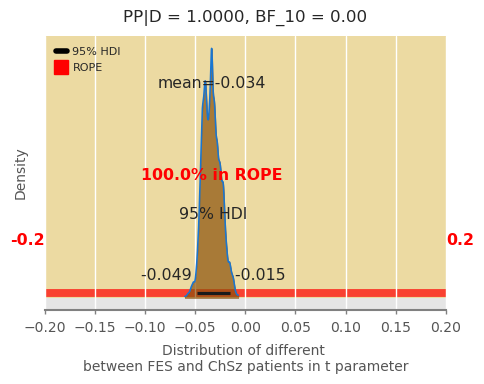

┌────────────┬───────────────┬───────────────┬───────────────┬────────────┬─────────┐
│ Parameter  │ Mean Difference │ 95% HDI Lower │ 95% HDI Upper │   PP|D    │ BF_{10} │
├────────────┼───────────────┼───────────────┼───────────────┼────────────┼─────────┤
│ t_C(Group, │        -0.0336 │       -0.0486 │       -0.0155 │     1.0000 │    0.00 │
└────────────┴───────────────┴───────────────┴───────────────┴────────────┴─────────┘


In [40]:
import arviz as az
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.lines import Line2D

# 配置全局样式
plt.style.use('ggplot')  # 更换图风格为 'ggplot'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['axes.labelpad'] = 10
plt.rcParams['xtick.major.pad'] = 5
plt.rcParams['ytick.major.pad'] = 5

# 定义模型和感兴趣的参数
model_data = {
    'm2t': ('t_C(Group, Treatment(\'2\'))[T.1]', m2t_infdata)  # 感兴趣的参数
}

# 创建单行图布局
fig, axes = plt.subplots(1, 1, figsize=(5, 4))  # 单个子图

# 存储结果的列表
results = []

# 遍历模型和参数
for model_name, (param, infdata) in model_data.items():
    # 提取后验样本
    posterior_samples = infdata.posterior[param].values.flatten()

    # 计算后验分布的均值和 95% HDI
    mean_diff = posterior_samples.mean()
    hdi_95_diff = az.hdi(posterior_samples, hdi_prob=0.95)

    # 计算 PP|D（差异是否接近0）
    ppd_diff = ((posterior_samples > -0.2) & (posterior_samples < 0.2)).mean()

    # 计算 BF_{10}
    bf_10_diff = (1 - ppd_diff) / ppd_diff

    # 绘制后验分布图
    az.plot_posterior(
        posterior_samples,
        kind='kde',
        hdi_prob=0.95,
        rope=[-0.2, 0.2],
        textsize=10,
        rope_color='red',
        ax=axes,
        color='#1976D2',
    )

    # 获取x和y坐标，用于填充
    x_vals = axes.lines[0].get_xdata()
    y_vals = axes.lines[0].get_ydata()

    # 使用 fill_between 方法进行填充
    axes.fill_between(x_vals, y_vals, color='#8c510a', alpha=0.7)

    # 设置图形格式
    axes.set_xlim(-0.2, 0.2)  # 根据数据范围调整 X 轴范围
    axes.set_xlabel(f'Distribution of different \nbetween FES and ChSz patients in t parameter', fontsize=10, labelpad=6)
    axes.set_ylabel('Density', fontsize=10, labelpad=12)
    axes.set_title(f'PP|D = {ppd_diff:.4f}, BF_{10} = {bf_10_diff:.2f}', fontsize=12, pad=10)

    # 添加填充矩形
    rect = plt.Rectangle((-0.2, 0), 0.4, axes.get_ylim()[1], 
                         linewidth=0, facecolor='#FFC107', alpha=0.3,
                         zorder=-1)
    axes.add_patch(rect)

    # 自定义图例符号
    custom_lines = [
        Line2D([0], [0], color='black', lw=4),  # 黑色线，表示95% HDI
        Line2D([0], [0], color='red', marker='s', markersize=10, linestyle='None')  # 红色方块，表示ROPE
    ]

    # 添加图例
    axes.legend(custom_lines, ["95% HDI", "ROPE"], loc='upper left', fontsize=8, 
                frameon=False, edgecolor='none', fancybox=False, 
                borderpad=0.5, handlelength=1.0, handletextpad=0.5)

    # 存储结果
    results.append({
        "Parameter": param,
        "Mean Difference": mean_diff,
        "95% HDI Lower": hdi_95_diff[0],
        "95% HDI Upper": hdi_95_diff[1],
        "PP|D": ppd_diff,
        "BF_{10}": bf_10_diff
    })

# 调整布局和显示图像
plt.tight_layout()
plt.savefig('6.统计推断-输出/组间差异/a_C_Group_Treatment_2_m2t.jpg', dpi=1200, bbox_inches='tight', transparent=True)  # 设置透明背景
plt.show()

# 将结果转换为 DataFrame 并打印为三线表
df_results = pd.DataFrame(results)

# 格式化数值
df_results['Mean Difference'] = df_results['Mean Difference'].map('{:.4f}'.format)
df_results['95% HDI Lower'] = df_results['95% HDI Lower'].map('{:.4f}'.format)
df_results['95% HDI Upper'] = df_results['95% HDI Upper'].map('{:.4f}'.format)
df_results['PP|D'] = df_results['PP|D'].map('{:.4f}'.format)
df_results['BF_{10}'] = df_results['BF_{10}'].map('{:.2f}'.format)

# 打印为三线表格式
print("┌────────────┬───────────────┬───────────────┬───────────────┬────────────┬─────────┐")
print("│ Parameter  │ Mean Difference │ 95% HDI Lower │ 95% HDI Upper │   PP|D    │ BF_{10} │")
print("├────────────┼───────────────┼───────────────┼───────────────┼────────────┼─────────┤")
for index, row in df_results.iterrows():
    print(f"│ {row['Parameter'][:10]:>10} │ {row['Mean Difference']:>14} │ {row['95% HDI Lower']:>13} │ {row['95% HDI Upper']:>13} │ {row['PP|D']:>10} │ {row['BF_{10}']:>7} │")
print("└────────────┴───────────────┴───────────────┴───────────────┴────────────┴─────────┘")

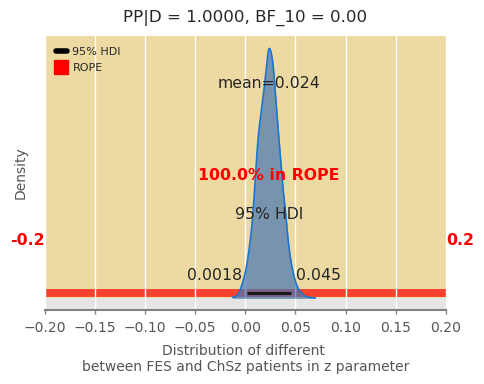

┌────────────┬───────────────┬───────────────┬───────────────┬────────────┬─────────┐
│ Parameter  │ Mean Difference │ 95% HDI Lower │ 95% HDI Upper │   PP|D    │ BF_{10} │
├────────────┼───────────────┼───────────────┼───────────────┼────────────┼─────────┤
│ z_C(Group, │         0.0237 │        0.0018 │        0.0453 │     1.0000 │    0.00 │
└────────────┴───────────────┴───────────────┴───────────────┴────────────┴─────────┘


In [41]:
import arviz as az
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.lines import Line2D

# 配置全局样式
plt.style.use('ggplot')  # 更换图风格为 'ggplot'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['axes.labelpad'] = 10
plt.rcParams['xtick.major.pad'] = 5
plt.rcParams['ytick.major.pad'] = 5

# 定义模型和感兴趣的参数
model_data = {
    'm2z': ('z_C(Group, Treatment(\'2\'))[T.1]', m2z_infdata)  # 感兴趣的参数
}

# 创建单行图布局
fig, axes = plt.subplots(1, 1, figsize=(5, 4))  # 单个子图

# 存储结果的列表
results = []

# 遍历模型和参数
for model_name, (param, infdata) in model_data.items():
    # 提取后验样本
    posterior_samples = infdata.posterior[param].values.flatten()

    # 计算后验分布的均值和 95% HDI
    mean_diff = posterior_samples.mean()
    hdi_95_diff = az.hdi(posterior_samples, hdi_prob=0.95)

    # 计算 PP|D（差异是否接近0）
    ppd_diff = ((posterior_samples > -0.2) & (posterior_samples < 0.2)).mean()

    # 计算 BF_{10}
    bf_10_diff = (1 - ppd_diff) / ppd_diff

    # 绘制后验分布图
    az.plot_posterior(
        posterior_samples,
        kind='kde',
        hdi_prob=0.95,
        rope=[-0.2, 0.2],
        textsize=10,
        rope_color='red',
        ax=axes,
        color='#1976D2',
    )

    # 获取x和y坐标，用于填充
    x_vals = axes.lines[0].get_xdata()
    y_vals = axes.lines[0].get_ydata()

    # 使用 fill_between 方法进行填充
    axes.fill_between(x_vals, y_vals, color='#4575b4', alpha=0.7)

    # 设置图形格式
    axes.set_xlim(-0.2, 0.2)  # 根据数据范围调整 X 轴范围
    axes.set_xlabel(f'Distribution of different \nbetween FES and ChSz patients in z parameter', fontsize=10, labelpad=6)
    axes.set_ylabel('Density', fontsize=10, labelpad=12)
    axes.set_title(f'PP|D = {ppd_diff:.4f}, BF_{10} = {bf_10_diff:.2f}', fontsize=12, pad=10)

    # 添加填充矩形
    rect = plt.Rectangle((-0.2, 0), 0.4, axes.get_ylim()[1], 
                         linewidth=0, facecolor='#FFC107', alpha=0.3,
                         zorder=-1)
    axes.add_patch(rect)

    # 自定义图例符号
    custom_lines = [
        Line2D([0], [0], color='black', lw=4),  # 黑色线，表示95% HDI
        Line2D([0], [0], color='red', marker='s', markersize=10, linestyle='None')  # 红色方块，表示ROPE
    ]

    # 添加图例
    axes.legend(custom_lines, ["95% HDI", "ROPE"], loc='upper left', fontsize=8, 
                frameon=False, edgecolor='none', fancybox=False, 
                borderpad=0.5, handlelength=1.0, handletextpad=0.5)

    # 存储结果
    results.append({
        "Parameter": param,
        "Mean Difference": mean_diff,
        "95% HDI Lower": hdi_95_diff[0],
        "95% HDI Upper": hdi_95_diff[1],
        "PP|D": ppd_diff,
        "BF_{10}": bf_10_diff
    })

# 调整布局和显示图像
plt.tight_layout()
plt.savefig('6.统计推断-输出/组间差异/a_C_Group_Treatment_2_m2z.jpg', dpi=1200, bbox_inches='tight', transparent=True)  # 设置透明背景
plt.show()

# 将结果转换为 DataFrame 并打印为三线表
df_results = pd.DataFrame(results)

# 格式化数值
df_results['Mean Difference'] = df_results['Mean Difference'].map('{:.4f}'.format)
df_results['95% HDI Lower'] = df_results['95% HDI Lower'].map('{:.4f}'.format)
df_results['95% HDI Upper'] = df_results['95% HDI Upper'].map('{:.4f}'.format)
df_results['PP|D'] = df_results['PP|D'].map('{:.4f}'.format)
df_results['BF_{10}'] = df_results['BF_{10}'].map('{:.2f}'.format)

# 打印为三线表格式
print("┌────────────┬───────────────┬───────────────┬───────────────┬────────────┬─────────┐")
print("│ Parameter  │ Mean Difference │ 95% HDI Lower │ 95% HDI Upper │   PP|D    │ BF_{10} │")
print("├────────────┼───────────────┼───────────────┼───────────────┼────────────┼─────────┤")
for index, row in df_results.iterrows():
    print(f"│ {row['Parameter'][:10]:>10} │ {row['Mean Difference']:>14} │ {row['95% HDI Lower']:>13} │ {row['95% HDI Upper']:>13} │ {row['PP|D']:>10} │ {row['BF_{10}']:>7} │")
print("└────────────┴───────────────┴───────────────┴───────────────┴────────────┴─────────┘")

In [42]:
print("代码全部完成!")

代码全部完成!
